In [1]:
# === Cell 1 (Corrected): Install dependencies without version pinning ===
!pip install \
    gradio \
    pandas \
    matplotlib \
    seaborn \
    scikit-learn \
    numpy \
    pillow \
    opencv-python \
    tensorflow

In [2]:
# === Cell 2 (Corrected): All imports ===

# 1) Standard library
import os, glob
import io, base64

# 2) Data & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3) TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW  # <-- FINAL CORRECTION HERE
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow_probability as tfp

# 4) TensorFlow Add-Ons is no longer needed

# 5) Scikit-learn utilities
from sklearn.utils.class_weight import compute_class_weight

# 6) OpenCV & PIL (for any image I/O)
import cv2
from PIL import Image
from IPython.display import display, HTML
from google.colab.patches import cv2_imshow
from google.colab import output, files
from google.colab import files

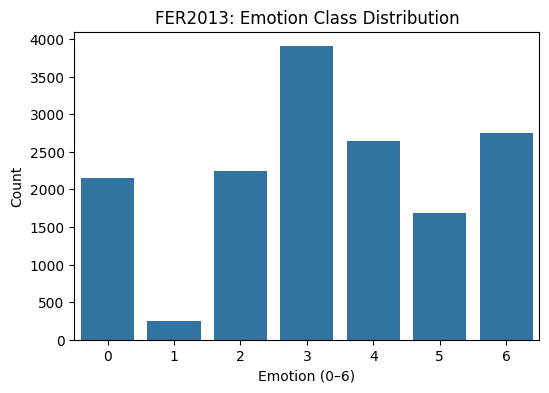

In [3]:
# === Cell 3a: EDA – Emotion class distribution ===
df = pd.read_csv('fer2013.csv')
plt.figure(figsize=(6,4))
sns.countplot(x='emotion', data=df)
plt.title("FER2013: Emotion Class Distribution")
plt.xlabel("Emotion (0–6)"); plt.ylabel("Count")
plt.show()


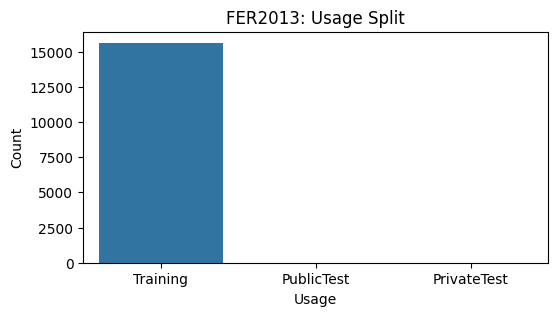

In [4]:
# === Cell 3b: EDA – Usage split ===
plt.figure(figsize=(6,3))
sns.countplot(x='Usage', data=df,
              order=['Training','PublicTest','PrivateTest'])
plt.title("FER2013: Usage Split"); plt.ylabel("Count")
plt.show()


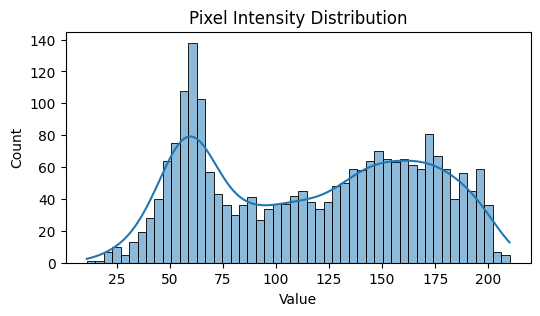

In [5]:
# === Cell 3c: EDA – Pixel intensity histogram (sample) ===
sample = np.fromstring(df.loc[0,'pixels'], dtype=int, sep=' ')
plt.figure(figsize=(6,3))
sns.histplot(sample, bins=50, kde=True)
plt.title("Pixel Intensity Distribution"); plt.xlabel("Value")
plt.show()


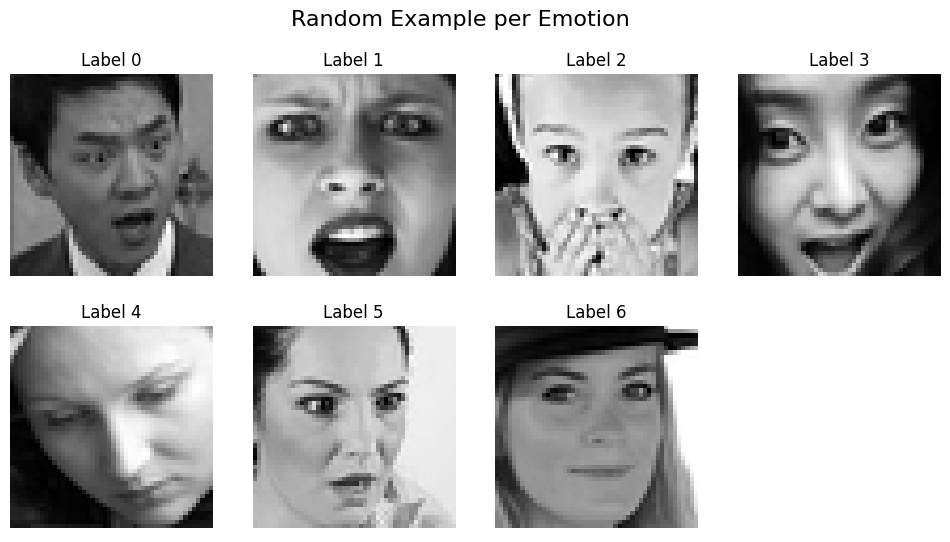

In [6]:
# === Cell 3d: EDA – One random example per emotion ===
fig, axes = plt.subplots(2,4, figsize=(12,6))
fig.suptitle("Random Example per Emotion", fontsize=16)
for emo in range(7):
    row = df[df.emotion==emo].sample(1).iloc[0]
    img = np.fromstring(row.pixels, dtype=int, sep=' ').reshape(48,48)
    ax = axes.flat[emo]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label {emo}")
    ax.axis('off')
axes.flat[-1].axis('off')
plt.show()


In [9]:
# === Cell 4: Convert pixel strings → 48×48×3 uint8 arrays ===

# 4.1: Drop any rows where ‘pixels’ doesn’t split into exactly 2304 values
expected_len = 48*48
mask = df['pixels'].apply(lambda s: isinstance(s, str) and len(s.split()) == expected_len)
num_bad = len(df) - mask.sum()
if num_bad:
    print(f"Dropping {num_bad} malformed rows (pixel‑count ≠ {expected_len})")
df = df.loc[mask].reset_index(drop=True)

# 4.2: Now safely convert each string to a (48,48,3) uint8 image
def str_to_arr(s: str) -> np.ndarray:
    pixels = s.split()                               # list of length 2304
    arr48  = np.array(pixels, dtype=np.uint8)        # flat array
    arr48  = arr48.reshape(48, 48)                   # to 2D
    return np.stack((arr48,)*3, axis=-1)             # duplicate → 3 channels

df['pixels_arr'] = df['pixels'].apply(str_to_arr)

print("Success — all images are now (48,48,3):", df['pixels_arr'].iloc[0].shape)


Success — all images are now (48,48,3): (48, 48, 3)


In [14]:
# === Cell 5: Split data, compute class_weights, and precompute per‑sample weights ===

# Examine unique values in the 'Usage' column
print("Unique values in 'Usage' column:", df['Usage'].unique())

train_df = df[df['Usage']=='Training']
val_df   = df[df['Usage']=='PublicTest']
test_df  = df[df['Usage']=='PrivateTest']

def extract(df_):
    # X: (N,48,48,3) uint8 images; y: (N,) integer labels 0–6
    # Check if the DataFrame is empty before stacking
    if df_.empty:
        return np.array([]), np.array([])
    X = np.stack(df_['pixels_arr'].values)
    y = df_['emotion'].values.astype(int)
    return X, y

X_train, y_train = extract(train_df)
X_val,   y_val   = extract(val_df)
X_test,  y_test  = extract(test_df)

# compute balanced class weights {label: weight}
classes = np.arange(7)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))

# precompute a sample_weights array to pass into .flow(...)
# sample_weights[i] = class_weights[y_train[i]]
sample_weights = np.array([ class_weights[label] for label in y_train ])

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Class weights:", class_weights)
print("Sample weights shape:", sample_weights.shape)

Unique values in 'Usage' column: ['Training']
Shapes: (15627, 48, 48, 3) (0,) (0,)
Class weights: {np.int64(0): np.float64(1.0383388704318937), np.int64(1): np.float64(8.929714285714285), np.int64(2): np.float64(0.9921904761904762), np.int64(3): np.float64(0.5724175824175824), np.int64(4): np.float64(0.8446570455651046), np.int64(5): np.float64(1.3233127275806589), np.int64(6): np.float64(0.812678766446513)}
Sample weights shape: (15627,)


In [16]:
# === Cell 6 (Corrected): build tf.data pipelines w/ reduced memory usage ===

# 0) Constants
num_classes  = 7
batch_size   = 32
img_height   = img_width = 128
AUTOTUNE     = tf.data.AUTOTUNE
n_train      = len(X_train)

# 1) Base datasets from arrays
base_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# Check if X_val is not empty before creating the dataset
if X_val.size > 0:
  base_val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val))
else:
  # Handle the case where X_val is empty, e.g., create an empty dataset or skip validation
  base_val_ds = tf.data.Dataset.from_tensor_slices((np.array([]), np.array([])))


# 2) Class-wise subsets for oversampling
class_ds = [
    base_train_ds.filter(lambda x, y, cls=cls: tf.equal(y, cls))
    for cls in range(num_classes)
]

# 3) Oversample minority classes
train_ds = tf.data.Dataset.sample_from_datasets(
    class_ds,
    weights=[1 / num_classes] * num_classes
)

# 4) Cap to exactly n_train examples
train_ds = train_ds.take(n_train)

# 5) Strong in-graph augmentation
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.1,0.1)
], name="strong_augmentation")

# 6) Preprocessing functions
def preprocess_train(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, [img_height, img_width])
    x = aug(x, training=True)
    x = preprocess_input(x)
    y = tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)
    return x, y

def preprocess_val(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, [img_height, img_width])
    x = preprocess_input(x)
    y = tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)
    return x, y

# 7) Final pipelines: map → shuffle/batch/prefetch
train_ds = (
    train_ds
      .map(preprocess_train, num_parallel_calls=AUTOTUNE)
      .shuffle(10000) # <-- FIX #2: Reduced shuffle buffer from 10,000 to 1000
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)

# Check if base_val_ds is not empty before mapping and batching
if base_val_ds.cardinality().numpy() > 0:
    val_ds = (
        base_val_ds
          .map(preprocess_val, num_parallel_calls=AUTOTUNE)
          .batch(batch_size)
          .prefetch(AUTOTUNE)
    )
else:
    # Handle the case where base_val_ds is empty, e.g., set val_ds to None or an empty dataset
    val_ds = None


print(f"Prepared train_ds (oversampled to {n_train} examples) and val_ds at {img_height}×{img_width}, batch_size={batch_size}")

Prepared train_ds (oversampled to 15627 examples) and val_ds at 128×128, batch_size=32


In [18]:
# === Cell 7: Build, train and save MobileNetV2 with lower with lower LR schedule ===

# 1) Model definition
inp = Input(shape=(128, 128, 3), name="image_input")
backbone = MobileNetV2(
    include_top=False,
    weights="imagenet", # Added comma here
    input_tensor=inp,
    pooling="avg"
)
backbone.trainable = True

x = BatchNormalization(name="bn_head")(backbone.output)
x = Dropout(0.4, name="dropout_head")(x)
x = Dense(128, activation="relu", name="fc1")(x)
x = BatchNormalization(name="bn_fc1")(x)
x = Dropout(0.4, name="dropout_fc1")(x)
preds = Dense(num_classes, activation="softmax", name="predictions")(x)

model = Model(inputs=inp, outputs=preds, name="FER_MobileNetV2_full")
model.summary()

/tmp/ipython-input-732737144.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "FER_MobileNetV2_full"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,428,487 (9.26 MB)

 Trainable params: 2,391,559 (9.12 MB)

 Non-trainable params: 36,928 (144.25 KB)

In [ ]:
# === Cell 8: Compile, train, and save the model ===

# Define the learning rate schedule
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=1000,
    t_mul=1.0,
    m_mul=1.0,
    alpha=0.0
)

# Define the optimizer
optimizer = AdamW(learning_rate=lr_schedule)

# Define the loss function
loss = CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('FER_MobileNetV2_best.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
# Check if val_ds is not None before fitting with validation data
if val_ds is not None:
    history = model.fit(
        train_ds,
        epochs=50, # You can adjust the number of epochs
        callbacks=callbacks,
        validation_data=val_ds,
        class_weight=class_weights # Use class weights for training
    )
else:
    print("Validation dataset is empty, training without validation data.")
    history = model.fit(
        train_ds,
        epochs=50, # You can adjust the number of epochs
        callbacks=callbacks,
        class_weight=class_weights # Use class weights for training
    )

print("Model training finished and saved to FER_MobileNetV2_best.h5")

In [13]:
# @title
# === Cell 8: Left-Aligned Webcam & Upload UI with Continuous Emotion Prediction ===

# --- Constants ---
VIDEO_WIDTH, VIDEO_HEIGHT = 640, 480
IMAGE_SIZE = 128 # model input height/width

# --- Load model & build single-trace inference fn ---
model = load_model("FER_MobileNetV2_best.h5")
@tf.function
def predict_fn(x):
    # run the model in inference mode, returns (batch, 7) tensor
    return model(x, training=False)

# --- Emotion labels & face detector ---
emotion_labels = {
    0: "Angry", 1: "Disgust", 2: "Fear",
    3: "Happy", 4: "Sad",     5: "Surprise",
    6: "Neutral"
}
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# --- Helper: detect faces, preprocess, predict, annotate ---
def annotate_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(face_rgb, (IMAGE_SIZE, IMAGE_SIZE))
        inp = preprocess_input(resized.astype("float32"))
        inp = tf.expand_dims(inp, axis=0)  # shape (1, IMAGE_SIZE, IMAGE_SIZE, 3)
        preds = predict_fn(inp).numpy()[0]
        idx = int(np.argmax(preds))
        label = emotion_labels.get(idx, "Unknown")
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return frame

# --- JavaScript UI: left-aligned video + bottom buttons ---
def start_webcam_ui():
    js = rf"""
    <script>
      const cid = 'emotion-container';
      document.getElementById(cid)?.remove();
      const c = document.createElement('div');
      c.id = cid;
      c.style.display = 'flex';
      c.style.flexDirection = 'column';
      c.style.alignItems = 'flex-start';
      c.style.margin = '10px';
      document.body.appendChild(c);

      const v = document.createElement('video');
      v.width = {VIDEO_WIDTH}; v.height = {VIDEO_HEIGHT}; v.autoplay = true;
      c.appendChild(v);

      navigator.mediaDevices.getUserMedia({{video:true}})
        .then(s => {{
          v.srcObject = s;
          setTimeout(() => {{
            const bar = document.createElement('div');
            bar.style.marginTop = '10px';
            c.appendChild(bar);

            const snap = document.createElement('button');
            snap.textContent = 'Capture Photo';
            bar.appendChild(snap);

            const upl = document.createElement('button');
            upl.textContent = 'Upload Image';
            bar.appendChild(upl);

            snap.onclick = () => {{
              const canvas = document.createElement('canvas');
              canvas.width = {VIDEO_WIDTH};
              canvas.height = {VIDEO_HEIGHT};
              canvas.getContext('2d').drawImage(v, 0, 0);
              const dataUrl = canvas.toDataURL('image/png');
              google.colab.kernel.invokeFunction('notebook.on_capture', [dataUrl], {{}});
            }};
            upl.onclick = () => {{
              google.colab.kernel.invokeFunction('notebook.on_upload', [], {{}});
            }};
          }}, 1000);
        }})
        .catch(e => alert('Webcam not accessible: ' + e));
    </script>
    """
    display(HTML(js))

# --- Callback: process a captured screenshot ---
def on_capture(dataUrl):
    header, encoded = dataUrl.split(",", 1)
    img = Image.open(io.BytesIO(base64.b64decode(encoded))).convert("RGB")
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    # frame is already VIDEO_WIDTH×VIDEO_HEIGHT
    annotated = annotate_frame(frame)
    cv2_imshow(annotated)

# --- Callback: process an uploaded image ---
def on_upload():
    uploaded = files.upload()
    for fname in uploaded:
        img = Image.open(fname).convert("RGB")
        frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        frame = cv2.resize(frame, (VIDEO_WIDTH, VIDEO_HEIGHT))
        annotated = annotate_frame(frame)
        cv2_imshow(annotated)

# --- Register callbacks & launch UI ---
output.register_callback('notebook.on_capture', on_capture)
output.register_callback('notebook.on_upload', on_upload)
start_webcam_ui()


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'FER_MobileNetV2_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)